# ML Summer School Project 1 

## Deep Learning with MNIST dataset and Dog Cat classification dataset

### Importing Required libraries - 

In [1]:
import torch                                                                # importing pytorch 
from torch import nn                                                        # importing the nn class from the torch 
import numpy as np                                                          # numpy is the mathematical library for python 
import pandas as pd                                                         # for data preprocessing
import matplotlib.pyplot as plt                                             # Data Visualisation Library for python 
# import seaborn as sns                                                       # datavisualisation lib
import torchvision.transforms as transforms                                 # contains various transforms to apply to the dataset 
from torchvision.datasets import MNIST                                      # importing the Mnist dataset from the torchvision library
import sklearn                                                              # ML assistance 
from sklearn.model_selection import train_test_split                        # function for spliting the data into train, val and test sets
from torchvision.transforms import ToTensor                                 # function used for converting the images into tensors 
from torch.utils.data import DataLoader                                     # to make the dataset an python iterable 

### Loading data from the `torchvision.datasets.MNIST` -

In [3]:
train_val_data = MNIST(
    root = "data",                                                          # this is the root directory in which we want our dataset
    train=True,                                                             # this signifies that this is the training data 
    transform=ToTensor(),                                                   # this is to transform the data into the tensor form
    target_transform=None,                                                  # takes in the target and transforms it
    download=False
)

test_data = MNIST(
    root = "data",
    train = False,
    transform=ToTensor(),
    target_transform=None,
    download=False
)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
from torch.utils.data import random_split
train_size = int(0.8 * len(train_val_data))
val_size = len(train_val_data) - train_size
train_data, val_data = random_split(train_val_data, [train_size, val_size])


### Analysing the data

In [6]:
# Analysing the Label Values from the data 

class_names = train_val_data.classes

In [7]:
test_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

### Visualisation of the data

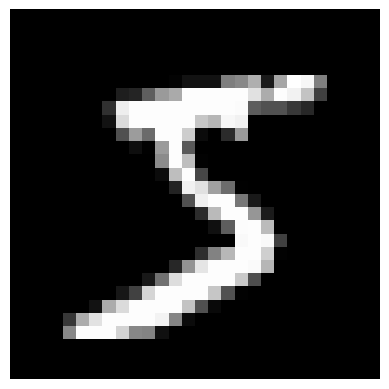

In [8]:
from PIL import Image

def show_image(image):
    image_np = image.numpy()
    
    image_np = image_np.transpose((1,2,0))
    
    plt.imshow(image_np.squeeze(), cmap = "gray")
    plt.axis('off')
    plt.show()

image, label = train_val_data[0]                            # the train dataset contains the image and the labels 
show_image(image) 

### visualizing multiple images 

Function to print multiple images from the train dataset with the labels as there headings 
- basically making a figure of figsize = (r*c, r*c)
- then running a loop over the training set for r*c times 
- taking a random index every time
- adding a subplot of size (r,c) at the i th position 
- showing the image there of that random index

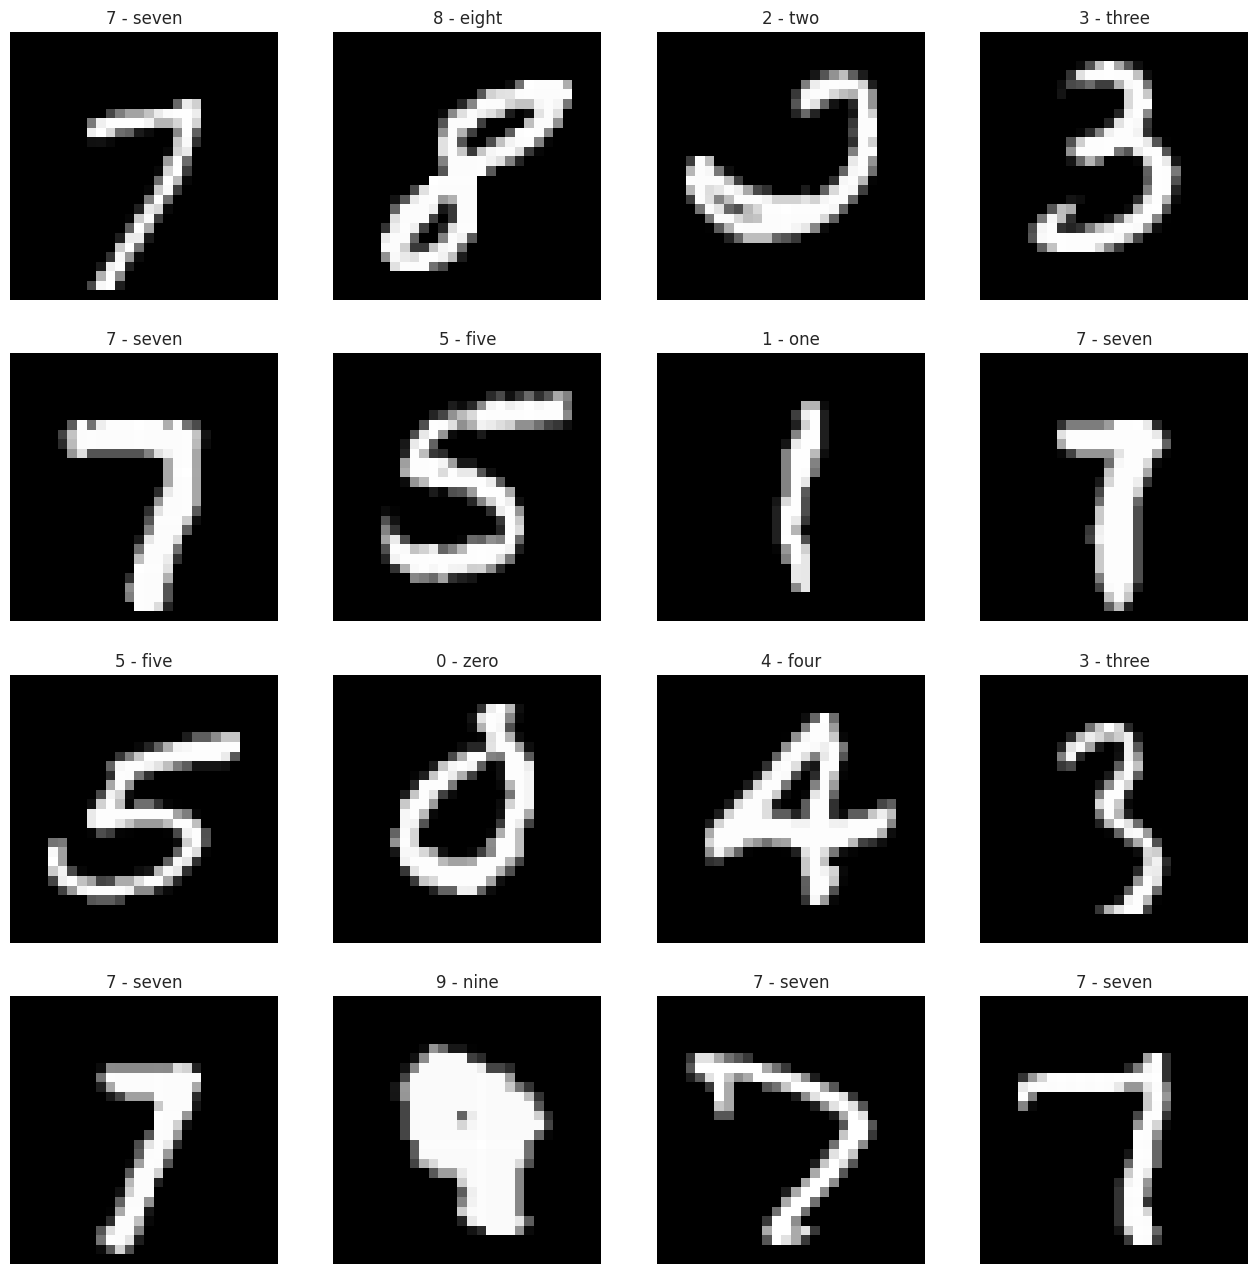

In [9]:
rows, columns = 4,4
fig = plt.figure(figsize=(rows*columns, rows*columns))
for i in range(1, rows*columns+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows,columns,i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
 

In [10]:
# getting the number of images for each of the class 
from collections import Counter

train_classes = [label for i , label in train_data]
frequency = dict(Counter(train_classes))

# plt.hist(frequency)

### Creating DataLoaders for our data- 

- dataloaders are used to basically make the mini batches for the training of the data
- it creates out dataset a python iterable

In [272]:
train_dataloader = DataLoader(train_data, 64, True)
val_dataloader = DataLoader(val_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=True)

In [273]:
next(iter(train_dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [274]:
train_features, train_labels = next(iter(train_dataloader))
print(f"no. of train features - {train_features.size()}")
print(f"no. of train labels - {train_labels.size()}")

no. of train features - torch.Size([64, 1, 28, 28])
no. of train labels - torch.Size([64])


## Model 1 : Fully Connected Model-
    - model using only fully connected layers and no convolutional layers
    - basically making a normal neural network to test its accuracy

In [275]:
class MNISTv0(nn.Module):                                    # inhereting the parent class nn.module for our models, will do this in every model for pytorch
    def __init__(self, input_shape:int, 
                 output_shape:int):
        """
        initializes FashionMNIST model 
        
        args:
            input_shape (int): shape of input images
            output_shape (int): shape of output images
        """
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(in_features=input_shape, out_features=512, bias=True)                           # total number of parameters in this layer = (784+1)*(512) = 401920
        self.layer2 = nn.Linear(in_features=512, out_features=256, bias=True)                                   # total number of parameters in this layer = (512+1)*256 = 131328
        self.layer3 = nn.Linear(in_features=256, out_features=output_shape, bias=True)                          # total number of parameters in this layer = (256+1)*10 = 2570
        self.relu = nn.ReLU()
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(self.flatten(x))))))

In [276]:
model_0 = MNISTv0(input_shape=28*28, output_shape=len(class_names))
model_0

MNISTv0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

In [277]:
sum(p.numel() for p in model_0.parameters() if p.requires_grad)                                # total numebr of parameters for this model = 401920+131328+2570 = 535818


535818

In [278]:
from torchsummary import summary
input_shape = 784
summary(model_0, input_size=(1, input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


## Initializing the optimizer and the loss function for the model training

In [279]:
from sklearn.metrics import accuracy_score
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [280]:
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    return correct / len(y_true) * 100

### Building Training and testing loops and functionsa

In [281]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    
    model.train()  # Set the model to training mode
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        
        train_loss += loss.item()  # Convert to scalar and accumulate
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))  # Go from logits -> pred labels
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [282]:
def val_step(data_loader: torch.utils.data.DataLoader,
             model: torch.nn.Module,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device):
    
    model.eval()  # Set the model to evaluation mode
    val_loss, val_acc = 0, 0

    with torch.inference_mode():  # Disable gradient computation
        for X, y in data_loader:
            val_pred = model(X)  # Perform a forward pass through the model
            
            # Calculate loss and accuracy
            val_loss += loss_fn(val_pred, y).item()
            val_acc += accuracy_fn(y_true=y,
                                   y_pred=val_pred.argmax(dim=1))  # Go from logits -> pred labels
    
    val_loss /= len(data_loader)
    val_acc /= len(data_loader)
    
    return val_loss, val_acc

In [283]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    test_loss, test_acc = 0, 0
    
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Disable gradient computation
        for X, y in data_loader:
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y) # Convert to scalar and accumulate
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))  # Go from logits -> pred labels
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

## Training our first fully connected network

In [284]:
torch.manual_seed(42)
from tqdm import tqdm

# Training loop
epochs = 10
best_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train_step(model=model_0, data_loader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer, device=device)
    
    val_loss, val_accuracy = val_step(data_loader=val_dataloader, model=model_0, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
    
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_0.state_dict(), 'best_model_fcc1.pth')



 10%|█         | 1/10 [00:07<01:10,  7.85s/it]

Epoch 1/10, Train Loss: 1.8085, Train Accuracy: 59.91%, Val Loss: 0.9270, Val Accuracy: 81.03%


 20%|██        | 2/10 [00:14<00:57,  7.24s/it]

Epoch 2/10, Train Loss: 0.6218, Train Accuracy: 84.60%, Val Loss: 0.4729, Val Accuracy: 87.35%


 30%|███       | 3/10 [00:21<00:50,  7.15s/it]

Epoch 3/10, Train Loss: 0.4194, Train Accuracy: 88.45%, Val Loss: 0.3826, Val Accuracy: 89.28%


 40%|████      | 4/10 [00:28<00:41,  6.95s/it]

Epoch 4/10, Train Loss: 0.3576, Train Accuracy: 89.95%, Val Loss: 0.3438, Val Accuracy: 90.27%


 50%|█████     | 5/10 [00:34<00:34,  6.84s/it]

Epoch 5/10, Train Loss: 0.3239, Train Accuracy: 90.86%, Val Loss: 0.3196, Val Accuracy: 90.92%


 60%|██████    | 6/10 [00:42<00:28,  7.10s/it]

Epoch 6/10, Train Loss: 0.2999, Train Accuracy: 91.48%, Val Loss: 0.2991, Val Accuracy: 91.46%


 70%|███████   | 7/10 [00:50<00:21,  7.28s/it]

Epoch 7/10, Train Loss: 0.2806, Train Accuracy: 91.96%, Val Loss: 0.2849, Val Accuracy: 91.71%


 80%|████████  | 8/10 [00:57<00:14,  7.37s/it]

Epoch 8/10, Train Loss: 0.2644, Train Accuracy: 92.44%, Val Loss: 0.2731, Val Accuracy: 92.12%


 90%|█████████ | 9/10 [01:05<00:07,  7.53s/it]

Epoch 9/10, Train Loss: 0.2495, Train Accuracy: 92.91%, Val Loss: 0.2575, Val Accuracy: 92.59%


100%|██████████| 10/10 [01:13<00:00,  7.35s/it]

Epoch 10/10, Train Loss: 0.2361, Train Accuracy: 93.31%, Val Loss: 0.2475, Val Accuracy: 93.08%


In [285]:

# for testing 
# Load the best model for testing
model_0.load_state_dict(torch.load('best_model_fcc1.pth'))
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model_0, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.2291, Test Accuracy: 93.47%


## using K Fold validation

In [286]:
from sklearn.model_selection import KFold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
num_epochs = 5


In [287]:
# Define empty lists to store losses and accuracies
training_losses = []
validation_losses = []


# Training loop for k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(train_val_data)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Initialize model, optimizer, criterion for each fold
    model = MNISTv0(input_shape= 784, output_shape=10)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    fold_training_losses = []
    fold_validation_losses = []


    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    
    train_loader = DataLoader(dataset=train_val_data, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(dataset=train_val_data, sampler=val_sampler)
    
    for epoch in range(num_epochs):
        # Reset model parameters for each epoch
        model.train()
        optimizer.zero_grad()
        
        train_loss, train_accuracy = train_step(model=model, data_loader=train_loader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer, device=device)
        val_loss, val_accuracy = val_step(data_loader=val_loader, model=model, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
        
        fold_training_losses.append(train_loss)
        fold_validation_losses.append(val_loss)
 
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    training_losses.append(fold_training_losses)
    validation_losses.append(fold_validation_losses)


print('K-fold cross-validation completed.')


Fold 1/5
Epoch 1/5, Train Loss: 1.7765, Train Accuracy: 62.74%, Val Loss: 0.9104, Val Accuracy: 79.90%
Epoch 2/5, Train Loss: 0.6179, Train Accuracy: 84.59%, Val Loss: 0.4653, Val Accuracy: 87.28%
Epoch 3/5, Train Loss: 0.4188, Train Accuracy: 88.49%, Val Loss: 0.3780, Val Accuracy: 89.45%
Epoch 4/5, Train Loss: 0.3585, Train Accuracy: 89.87%, Val Loss: 0.3384, Val Accuracy: 90.12%
Epoch 5/5, Train Loss: 0.3261, Train Accuracy: 90.73%, Val Loss: 0.3153, Val Accuracy: 90.87%
Fold 2/5
Epoch 1/5, Train Loss: 1.7649, Train Accuracy: 61.13%, Val Loss: 0.8933, Val Accuracy: 80.30%
Epoch 2/5, Train Loss: 0.6113, Train Accuracy: 84.59%, Val Loss: 0.4725, Val Accuracy: 87.38%
Epoch 3/5, Train Loss: 0.4197, Train Accuracy: 88.43%, Val Loss: 0.3879, Val Accuracy: 89.36%
Epoch 4/5, Train Loss: 0.3595, Train Accuracy: 89.75%, Val Loss: 0.3484, Val Accuracy: 90.55%
Epoch 5/5, Train Loss: 0.3259, Train Accuracy: 90.70%, Val Loss: 0.3222, Val Accuracy: 91.18%
Fold 3/5
Epoch 1/5, Train Loss: 1.8173, Tr

In [288]:
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.3036, Test Accuracy: 91.29%


## Model 2 : Comvolutional Neural Network
    - model using convo2d layers and fully connected layers
    - the conv blocks with the max pooling is used to extract useful features and along with that decrease the number of parameters the fully connected layer has to process resulting in lesser computational usage 

In [289]:
class MNISTv1(nn.Module):
    def __init__(self, output_shape: int):
        super(MNISTv1, self).__init__()
        """
        Initializes the MNIST model
        
        Args:
            output_shape (int): shape of output (number of classes)
        """
        self.conv_layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, stride=1),  # params = (kernel size +1)*no. of filters = (9+1)*64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1), # Number of weights=in_channels×out_channels×kernel_height×kernel_width
                                                                                             # 64*128*3*3 = 73728
                                                                                             # params = number of weights + number of bias = 73728 + 128 = 73,856
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.conv_layer_stack2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1), # 128*64*3*3 + 64 = 73,792
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=1), #64*32*3*3 + 32 = 18,464
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.flatten = nn.Flatten()
        self.fcc = nn.Sequential(
            nn.Linear(in_features=32 * 7 * 7, out_features=128), # params = 32×7×7=1568*128 = 200704+128 = 200832
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64), # params = (128+1)*64 = 8256
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=output_shape) # params = (64+1)*10 = 650
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layer_stack(x)
        x = self.conv_layer_stack2(x)
        x = self.flatten(x)
        x = self.fcc(x)
        return x

# Example usage
model_1 = MNISTv1(output_shape=10)
print(model_1)




MNISTv1(
  (conv_layer_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_stack2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [290]:
from torchsummary import summary
input_shape = (1,28,28)
summary(model_1, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]          73,856
              ReLU-4          [-1, 128, 28, 28]               0
         MaxPool2d-5          [-1, 128, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          73,792
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]          18,464
              ReLU-9           [-1, 32, 14, 14]               0
        MaxPool2d-10             [-1, 32, 7, 7]               0
          Flatten-11                 [-1, 1568]               0
           Linear-12                  [-1, 128]         200,832
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [291]:
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [292]:
torch.manual_seed(42)

# Training loop
epochs = 10
best_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train_step(model=model_1, data_loader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer, device=device)
    
    val_loss, val_accuracy = val_step(data_loader=val_dataloader, model=model_1, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
    
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_0.state_dict(), 'best_model_cnn1.pth')



 10%|█         | 1/10 [03:41<33:15, 221.71s/it]

Epoch 1/10, Train Loss: 2.3020, Train Accuracy: 10.78%, Val Loss: 2.3010, Val Accuracy: 10.69%


 20%|██        | 2/10 [07:53<31:54, 239.36s/it]

Epoch 2/10, Train Loss: 2.2983, Train Accuracy: 11.37%, Val Loss: 2.2954, Val Accuracy: 10.69%


 30%|███       | 3/10 [11:38<27:10, 232.98s/it]

Epoch 3/10, Train Loss: 1.7436, Train Accuracy: 40.98%, Val Loss: 0.5311, Val Accuracy: 83.88%


 40%|████      | 4/10 [15:38<23:33, 235.59s/it]

Epoch 4/10, Train Loss: 0.3657, Train Accuracy: 88.38%, Val Loss: 0.2697, Val Accuracy: 91.76%


 50%|█████     | 5/10 [19:31<19:34, 234.82s/it]

Epoch 5/10, Train Loss: 0.2168, Train Accuracy: 93.18%, Val Loss: 0.1628, Val Accuracy: 94.94%


 60%|██████    | 6/10 [23:41<15:59, 239.78s/it]

Epoch 6/10, Train Loss: 0.1502, Train Accuracy: 95.31%, Val Loss: 0.1267, Val Accuracy: 96.04%


 70%|███████   | 7/10 [27:16<11:35, 231.69s/it]

Epoch 7/10, Train Loss: 0.1149, Train Accuracy: 96.40%, Val Loss: 0.1045, Val Accuracy: 96.71%


 80%|████████  | 8/10 [31:20<07:51, 235.51s/it]

Epoch 8/10, Train Loss: 0.0928, Train Accuracy: 97.11%, Val Loss: 0.0932, Val Accuracy: 97.07%


 90%|█████████ | 9/10 [35:21<03:57, 237.49s/it]

Epoch 9/10, Train Loss: 0.0803, Train Accuracy: 97.51%, Val Loss: 0.0831, Val Accuracy: 97.41%


100%|██████████| 10/10 [39:47<00:00, 238.71s/it]

Epoch 10/10, Train Loss: 0.0702, Train Accuracy: 97.78%, Val Loss: 0.0700, Val Accuracy: 97.72%


In [293]:

# for testing 
# Load the best model for testing
model_0.load_state_dict(torch.load('best_model_cnn1.pth'))
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model_1, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0589, Test Accuracy: 98.12%


## using K fold Validation

In [294]:
from sklearn.model_selection import KFold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
num_epochs = 5


In [295]:
# Define empty lists to store losses and accuracies
training_losses = []
validation_losses = []


# Training loop for k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(train_val_data)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Initialize model, optimizer, criterion for each fold
    model1 = MNISTv1(output_shape=10)
    optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    fold_training_losses = []
    fold_validation_losses = []


    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    
    train_loader = DataLoader(dataset=train_val_data, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(dataset=train_val_data, sampler=val_sampler)
    
    for epoch in range(num_epochs):
        # Reset model parameters for each epoch
        model1.train()
        optimizer.zero_grad()
        
        train_loss, train_accuracy = train_step(model=model1, data_loader=train_loader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer, device=device)
        val_loss, val_accuracy = val_step(data_loader=val_loader, model=model1, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
        
        fold_training_losses.append(train_loss)
        fold_validation_losses.append(val_loss)
 
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    training_losses.append(fold_training_losses)
    validation_losses.append(fold_validation_losses)


print('K-fold cross-validation completed.')


Fold 1/5
Epoch 1/5, Train Loss: 2.3016, Train Accuracy: 10.70%, Val Loss: 2.2997, Val Accuracy: 11.29%
Epoch 2/5, Train Loss: 2.2978, Train Accuracy: 11.22%, Val Loss: 2.2929, Val Accuracy: 11.29%
Epoch 3/5, Train Loss: 1.8534, Train Accuracy: 37.57%, Val Loss: 0.5588, Val Accuracy: 82.26%
Epoch 4/5, Train Loss: 0.3874, Train Accuracy: 87.48%, Val Loss: 0.2944, Val Accuracy: 90.27%
Epoch 5/5, Train Loss: 0.2282, Train Accuracy: 92.77%, Val Loss: 0.1844, Val Accuracy: 94.08%
Fold 2/5
Epoch 1/5, Train Loss: 2.3028, Train Accuracy: 10.68%, Val Loss: 2.3000, Val Accuracy: 11.31%
Epoch 2/5, Train Loss: 2.2967, Train Accuracy: 11.22%, Val Loss: 2.2883, Val Accuracy: 11.31%
Epoch 3/5, Train Loss: 1.4053, Train Accuracy: 53.20%, Val Loss: 0.4429, Val Accuracy: 84.12%
Epoch 4/5, Train Loss: 0.3070, Train Accuracy: 90.24%, Val Loss: 0.2253, Val Accuracy: 93.19%
Epoch 5/5, Train Loss: 0.1912, Train Accuracy: 93.93%, Val Loss: 0.1634, Val Accuracy: 94.88%
Fold 3/5
Epoch 1/5, Train Loss: 2.3027, Tr

In [296]:
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model1, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.1489, Test Accuracy: 95.24%


## Model 2 : Fully Convolutional Neural Network
    - model using convo2d layers and fully connected layers
    - the conv blocks with the max pooling is used to extract useful features and along with that decrease the number of parameters the fully connected layer has to process resulting in lesser computational usage 

In [8]:
import torch
from torch import nn
class MNISTv2(nn.Module):
    def __init__(self, output_shape: int):
        super(MNISTv2, self).__init__()
        """
        Initializes the MNIST model
        
        Args:
            output_shape (int): shape of output (number of classes)
        """
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),               # params = (1*16*3*3) = 144 +16 = 160
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= 3),             # params = (16*32*3*) = 4608 + 32 = 4640
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        self.conv_stack2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),              # params = (32*64*3*3) = 18432 + 64 = 18496
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3),              # params = (32*64*3*3) = 18432 + 32 = 18464
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.conv_stack3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3),                # params = 32×16×3×3=4608 + 16 = 4624
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=output_shape, kernel_size=1),        # params = 16×10×1×1=160 +10 = 170
            nn.ReLU()
        )
        
    def forward(self, x:torch.Tensor)->torch.Tensor:
        x = self.conv_stack3(self.conv_stack2(self.conv_stack(x)))
        x = nn.Flatten(x.size(0), -1)
        return x
model_2 = MNISTv2(output_shape=10)
model_22 = MNISTv2(output_shape=10)
model_2

MNISTv2(
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
  )
)

In [298]:
input_shape = (1,28,28)
summary(model_2, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          18,496
              ReLU-7           [-1, 64, 10, 10]               0
            Conv2d-8             [-1, 32, 8, 8]          18,464
              ReLU-9             [-1, 32, 8, 8]               0
        MaxPool2d-10             [-1, 32, 4, 4]               0
           Conv2d-11             [-1, 16, 2, 2]           4,624
             ReLU-12             [-1, 16, 2, 2]               0
           Conv2d-13             [-1, 10, 2, 2]             170
             ReLU-14             [-1, 1

In [299]:
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [300]:
torch.manual_seed(42)

# Training loop
epochs = 10
best_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train_step(model=model_2, data_loader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer, device=device)
    
    val_loss, val_accuracy = val_step(data_loader=val_dataloader, model=model_2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
    
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_0.state_dict(), 'best_model_fcn1.pth')



 10%|█         | 1/10 [00:37<05:37, 37.48s/it]

Epoch 1/10, Train Loss: 2.3150, Train Accuracy: 27.16%, Val Loss: 1.4077, Val Accuracy: 54.33%


 20%|██        | 2/10 [01:14<04:58, 37.34s/it]

Epoch 2/10, Train Loss: 0.6916, Train Accuracy: 79.08%, Val Loss: 0.3881, Val Accuracy: 88.52%


 30%|███       | 3/10 [01:51<04:20, 37.22s/it]

Epoch 3/10, Train Loss: 0.3137, Train Accuracy: 90.78%, Val Loss: 0.2502, Val Accuracy: 92.71%


 40%|████      | 4/10 [02:28<03:42, 37.13s/it]

Epoch 4/10, Train Loss: 0.2263, Train Accuracy: 93.22%, Val Loss: 0.1919, Val Accuracy: 94.55%


 50%|█████     | 5/10 [03:05<03:05, 37.10s/it]

Epoch 5/10, Train Loss: 0.1868, Train Accuracy: 94.38%, Val Loss: 0.1657, Val Accuracy: 95.02%


 60%|██████    | 6/10 [03:42<02:28, 37.07s/it]

Epoch 6/10, Train Loss: 0.1633, Train Accuracy: 95.01%, Val Loss: 0.1490, Val Accuracy: 95.58%


 70%|███████   | 7/10 [04:19<01:51, 37.03s/it]

Epoch 7/10, Train Loss: 0.1454, Train Accuracy: 95.65%, Val Loss: 0.1477, Val Accuracy: 95.58%


 80%|████████  | 8/10 [04:56<01:14, 37.01s/it]

Epoch 8/10, Train Loss: 0.1323, Train Accuracy: 96.04%, Val Loss: 0.1354, Val Accuracy: 95.83%


 90%|█████████ | 9/10 [05:33<00:37, 37.01s/it]

Epoch 9/10, Train Loss: 0.1226, Train Accuracy: 96.32%, Val Loss: 0.1204, Val Accuracy: 96.33%


100%|██████████| 10/10 [06:11<00:00, 37.11s/it]

Epoch 10/10, Train Loss: 0.1141, Train Accuracy: 96.67%, Val Loss: 0.1259, Val Accuracy: 96.03%


In [301]:

# for testing 
# Load the best model for testing
model_0.load_state_dict(torch.load('best_model_fcn1.pth'))
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model_2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.1085, Test Accuracy: 96.40%


## K - Fold CrossValidation - 

In [302]:
from sklearn.model_selection import KFold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
num_epochs = 5


In [303]:
# Define empty lists to store losses and accuracies
training_losses = []
validation_losses = []


# Training loop for k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(train_val_data)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Initialize model, optimizer, criterion for each fold
    model2 = MNISTv2( output_shape=10)
    optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    fold_training_losses = []
    fold_validation_losses = []


    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    
    train_loader = DataLoader(dataset=train_val_data, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(dataset=train_val_data, sampler=val_sampler)
    
    for epoch in range(num_epochs):
        # Reset model parameters for each epoch
        model2.train()
        optimizer.zero_grad()
        
        train_loss, train_accuracy = train_step(model=model2, data_loader=train_loader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer, device=device)
        val_loss, val_accuracy = val_step(data_loader=val_loader, model=model2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
        
        fold_training_losses.append(train_loss)
        fold_validation_losses.append(val_loss)
 
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    training_losses.append(fold_training_losses)
    validation_losses.append(fold_validation_losses)


print('K-fold cross-validation completed.')


Fold 1/5
Epoch 1/5, Train Loss: 3.3543, Train Accuracy: 13.61%, Val Loss: 3.2385, Val Accuracy: 19.41%
Epoch 2/5, Train Loss: 2.3679, Train Accuracy: 30.53%, Val Loss: 1.2908, Val Accuracy: 60.45%
Epoch 3/5, Train Loss: 0.7097, Train Accuracy: 77.77%, Val Loss: 0.3618, Val Accuracy: 89.32%
Epoch 4/5, Train Loss: 0.3180, Train Accuracy: 90.49%, Val Loss: 0.2891, Val Accuracy: 91.37%
Epoch 5/5, Train Loss: 0.2341, Train Accuracy: 92.98%, Val Loss: 0.2249, Val Accuracy: 93.08%
Fold 2/5
Epoch 1/5, Train Loss: 3.3616, Train Accuracy: 11.26%, Val Loss: 3.2709, Val Accuracy: 14.92%
Epoch 2/5, Train Loss: 2.9648, Train Accuracy: 22.68%, Val Loss: 1.4693, Val Accuracy: 55.17%
Epoch 3/5, Train Loss: 0.7085, Train Accuracy: 78.48%, Val Loss: 0.3865, Val Accuracy: 88.24%
Epoch 4/5, Train Loss: 0.3311, Train Accuracy: 90.36%, Val Loss: 0.2907, Val Accuracy: 91.42%
Epoch 5/5, Train Loss: 0.2432, Train Accuracy: 92.90%, Val Loss: 0.2131, Val Accuracy: 93.83%
Fold 3/5
Epoch 1/5, Train Loss: 3.3861, Tr

In [304]:
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.1469, Test Accuracy: 95.27%
